# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

E:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Taking 100k datapoints

In [13]:
final = final.sample(100000)

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100000, 10)


1    84265
0    15735
Name: Score, dtype: int64

## sorting wrt TIME

In [15]:
final = final.sort_values('Time',ascending=True)
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...
417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,959990400,Research,I'm getting crazy.<p>Is it really impossible t...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...
417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,992217600,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...
346114,374420,B00004CI84,A1ZH086GZYL5MZ,Doug DeBolt,2,2,1,1013385600,"A little gross, a lot of fun",Michael Keaton was already on his way to being...
346053,374357,B00004CI84,A31RM5QU797HPJ,Drez,1,2,1,1024531200,"&quot;I'm the ghost with the most, babe&quot;",Simply put: Beetlejuice is the funniest comedy...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
There are 3 flavors of Charleston Chew and this one is my favorite and it is also the hardest 1 to find!  It's hard to even find these for a good price here in FL.  I can only find them in one place and they are rather expensive, whereas I can get these for 69 cents apiece up in WA.  These are addictive!  Gotta love the mixture of milk chocolate and strawberry nougat!  It will be an instant favorite!
Terrible, gritty, bland noodles that aren't anything near the consistency of wheat pasta. Under-spiced sauce with very little cheesy "bite". Pass on this one, and just use gluten-free cheese sauce packets on on a better 

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
There are 3 flavors of Charleston Chew and this one is my favorite and it is also the hardest 1 to find!  It's hard to even find these for a good price here in FL.  I can only find them in one place and they are rather expensive, whereas I can get these for 69 cents apiece up in WA.  These are addictive!  Gotta love the mixture of milk chocolate and strawberry nougat!  It will be an instant favorite!
Terrible, gritty, bland noodles that aren't anything near the consistency of wheat pasta. Under-spiced sauce with very little cheesy "bite". Pass on this one, and just use gluten-free cheese sauce packets on on a better 

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Terrible, gritty, bland noodles that are not anything near the consistency of wheat pasta. Under-spiced sauce with very little cheesy "bite". Pass on this one, and just use gluten-free cheese sauce packets on on a better pasta, such as Tinkyada is Brown Rice pasta or any other brand that actually tastes and feels like real pasta. This is a waste of money and a real let down from a company whose mac'n'cheese I really loved back when I ate gluten


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Terrible gritty bland noodles that are not anything near the consistency of wheat pasta Under spiced sauce with very little cheesy bite Pass on this one and just use gluten free cheese sauce packets on on a better pasta such as Tinkyada is Brown Rice pasta or any other brand that actually tastes and feels like real pasta This is a waste of money and a real let down from a company whose mac n cheese I really loved back when I ate gluten


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:54<00:00, 1819.43it/s]


In [25]:
preprocessed_reviews[1500]

'terrible gritty bland noodles not anything near consistency wheat pasta spiced sauce little cheesy bite pass one use gluten free cheese sauce packets better pasta tinkyada brown rice pasta brand actually tastes feels like real pasta waste money real let company whose mac n cheese really loved back ate gluten'

# [4] Featurization

## [4.1] TF-IDF

In [26]:
tfidf_vect = TfidfVectorizer(min_df = 10)
tfidf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tfidf_vect.get_feature_names()[0:10])
print('='*50)

tfidf = tfidf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(tfidf))
print("the shape of out text TFIDF vectorizer ",tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'abilities', 'ability', 'able']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 12528)
the number of unique words including both unigrams and bigrams  12528


# Truncated SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

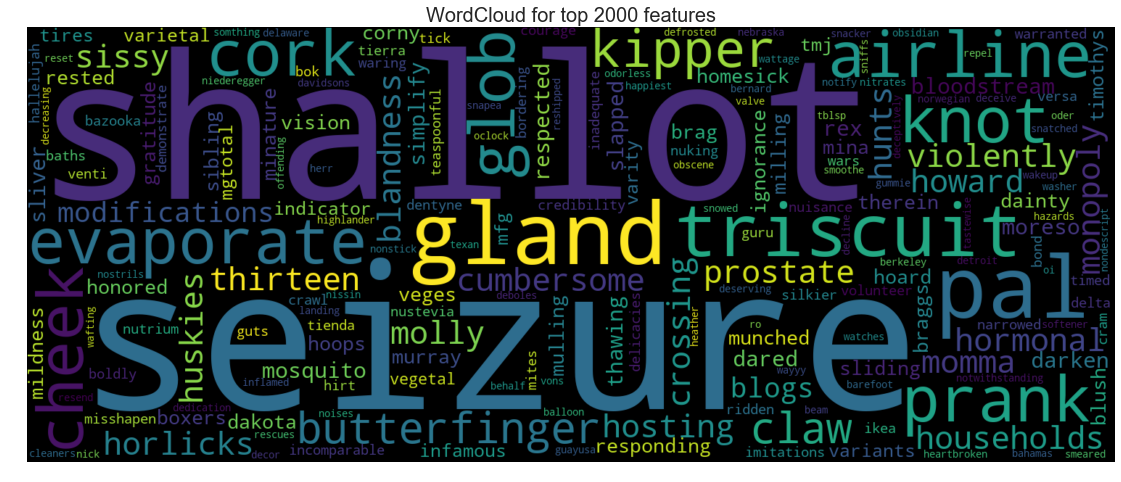

In [154]:
from wordcloud import WordCloud
#function for determiinging the top words are plottting wordcloud for it
features = tfidf_vect.get_feature_names()
# gettting all the feature names

indices = np.argsort(tfidf_vect.idf_)[::-1]#sorting the indices in descending order of the respective values

top_features = []
text = ' '
"""Computing top 2000 features"""
for i in indices[0:2000]:
    text = text + " " + features[i]
    top_features.append(features[i])
    
               
"""Word Cloud for top  2000 features   """
wordcloud = WordCloud(width=1500, height=600,stopwords = stopwords).generate(text) 
# plot the WordCloud image  
plt.figure(figsize = (30,8)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.title('WordCloud for top 2000 features',fontsize=20)
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show() 
    
    


In [155]:
top_features

['prostate',
 'violently',
 'horlicks',
 'hormonal',
 'cumbersome',
 'blandness',
 'hosting',
 'households',
 'monopoly',
 'howard',
 'thirteen',
 'crossing',
 'sissy',
 'momma',
 'molly',
 'hunts',
 'huskies',
 'modifications',
 'blogs',
 'bloodstream',
 'simplify',
 'moreso',
 'mosquito',
 'rex',
 'slapped',
 'thawing',
 'respected',
 'sliver',
 'darken',
 'dared',
 'responding',
 'hoard',
 'murray',
 'munched',
 'rested',
 'sliding',
 'homesick',
 'mulling',
 'therein',
 'dakota',
 'vision',
 'dainty',
 'honored',
 'hoops',
 'ignorance',
 'blush',
 'gratitude',
 'timothys',
 'minature',
 'boxers',
 'veges',
 'sibling',
 'mina',
 'milling',
 'corny',
 'mildness',
 'brag',
 'braggs',
 'indicator',
 'varity',
 'mgtotal',
 'mfg',
 'tires',
 'varietal',
 'variants',
 'infamous',
 'tmj',
 'vegetal',
 'incomparable',
 'credibility',
 'courage',
 'ikea',
 'silkier',
 'crawl',
 'tick',
 'versa',
 'mites',
 'bok',
 'boldly',
 'imitations',
 'misshapen',
 'bond',
 'tienda',
 'tierra',
 'cram',

### [5.2] Calulation of Co-occurrence matrix

In [156]:
#src = https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix,this link helped me in understanding
# window size and its implementation

def cooccurence_matrix(n,features,document):
    n_neighbor = n
    k = len(features)
    matrix = np.zeros((k,k))
    
    
    for row in (document):
        for index,word in enumerate(row):
            if word in features:
                for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(row)-1) + 1):
                    if row[j] in features:
                        matrix[features.index(word),features.index(row[j])] += 1
                
    
    return matrix
    


In [157]:
corpus = [i.split(" ") for i in preprocessed_reviews]
#evaluating for every word present in a particular review

X = cooccurence_matrix(5,top_features,corpus)


In [158]:
X = np.matrix(X)
X.shape

(2000, 2000)

In [159]:
X

matrix([[ 19.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,  11.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,  21., ...,   0.,   0.,   0.],
        ..., 
        [  0.,   0.,   0., ...,  14.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,  14.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,  15.]])

### [5.3] Finding optimal value for number of components (n) to be retained.

In [162]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=300)
X_tsvd = tsvd.fit(X)

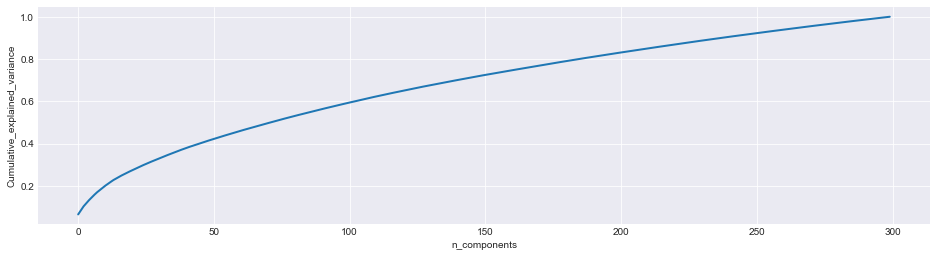

In [164]:
#elbow method for getting the right number of components
percentage_var_explained = tsvd.explained_variance_ratio_/ np.sum(tsvd.explained_variance_ratio_);
cum_var_explained = np.cumsum(percentage_var_explained)
# Plot the spectrum

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))
#plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
#plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()




In [165]:
for i in range(100,300,20):
    print('with {} number of components we can expalin {}% variance in the data'.format(i,cum_var_explained[i]*100))

with 100 number of components we can expalin 59.4292702832613% variance in the data
with 120 number of components we can expalin 65.09227375765748% variance in the data
with 140 number of components we can expalin 70.13274479599113% variance in the data
with 160 number of components we can expalin 74.72776586832312% variance in the data
with 180 number of components we can expalin 79.0668163612765% variance in the data
with 200 number of components we can expalin 83.10733844625815% variance in the data
with 220 number of components we can expalin 86.92626895923348% variance in the data
with 240 number of components we can expalin 90.53925063681211% variance in the data
with 260 number of components we can expalin 93.92408343542623% variance in the data
with 280 number of components we can expalin 97.1289775598835% variance in the data


so we can take around 280 dimensions 

In [166]:
""" U = svd.fit_transform(X)
   Sigma = svd.singular_values_
   VT = svd.components_"""


svd = TruncatedSVD(n_components = 280)
U = svd.fit_transform(X)

### [5.4] Applying k-means clustering

In [167]:
# finding the best k
from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10,11]
loss = []
for i in tqdm(k_values):
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(U)
    loss.append(kmeans.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.58s/it]


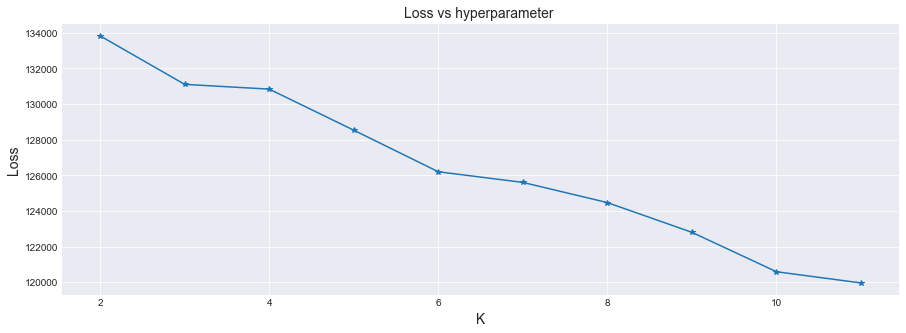

In [168]:
# elbow method to plot loss vs hyperparameter

sns.set_style('darkgrid')
    
plt.figure(figsize=(15,5))
plt.plot(k_values,loss,'-*')
#plot for the values
plt.title('Loss vs hyperparameter ',fontsize=14)
plt.xlabel('K',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.show()
    


from the graph we can deduce that the optimal value of Number of clusters is 7 from elbow method

In [169]:
# traiing the model with optimal number of clusters
model = KMeans(n_clusters=7, n_jobs=-1)
final = model.fit_transform(U)
final.shape

(2000, 7)

In [171]:
model.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [172]:
# Getting all the reviews in different clusters
class_0 = []
classs_1 = []
class_2 = []
class_3 = []
class_4 = []
class_5 = []
class_6 = []
class_7 = []

Text  = preprocessed_reviews
for i in range(U.shape[0]):
    if model.labels_[i] == 0:
        class_0.append(Text[i])
    elif model.labels_[i] == 1:
        class_1.append(Text[i])
    elif model.labels_[i] == 2:
        class_2.append(Text[i])
    elif model.labels_[i] == 3:
        class_3.append(Text[i])
    elif model.labels_[i] == 4:
        class_4.append(Text[i])
    elif model.labels_[i] == 5:
        class_5.append(Text[i])
    elif model.labels_[i] == 6:
        class_6.append(Text[i])
    else :
        class_7.append(Text[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-0 : ",len(class_0))
print("\nNo. of reviews in Cluster-1 : ",len(class_1))
print("\nNo. of reviews in Cluster-2 : ",len(class_2))
print("\nNo. of reviews in Cluster-3 : ",len(class_3))
print("\nNo. of reviews in Cluster-4 : ",len(class_4))
print("\nNo. of reviews in Cluster-5 : ",len(class_5))
print("\nNo. of reviews in Cluster-6 : ",len(class_6))
print("\nNo. of reviews in Cluster-7 : ",len(class_7))


No. of reviews in Cluster-0 :  1994

No. of reviews in Cluster-1 :  6

No. of reviews in Cluster-2 :  1

No. of reviews in Cluster-3 :  1

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  1

No. of reviews in Cluster-6 :  1

No. of reviews in Cluster-7 :  0


### [5.5] Wordclouds of clusters obtained in the above section

In [173]:
# Please write all the code with proper documentation
def wordcloud(features):
    
    text = " "
    for i in features:
        text = text + " " + i
    wordcloud = WordCloud(width=1500, height=600,stopwords = stopwords).generate(text) 
    # plot the WordCloud image  
    plt.figure(figsize = (30,8)) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    #plt.title('WordCloud for top 2000 features',fontsize=20)
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show()

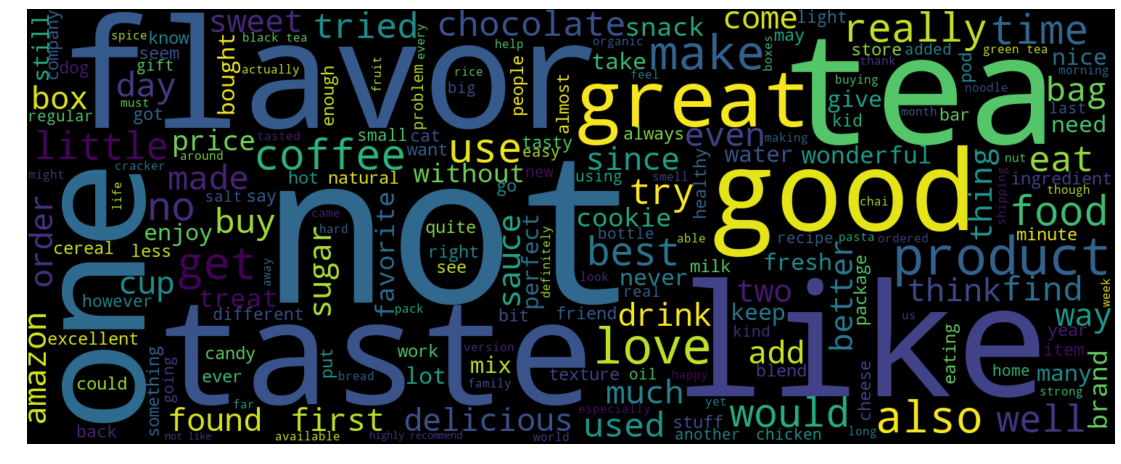

In [174]:
wordcloud(class_0)

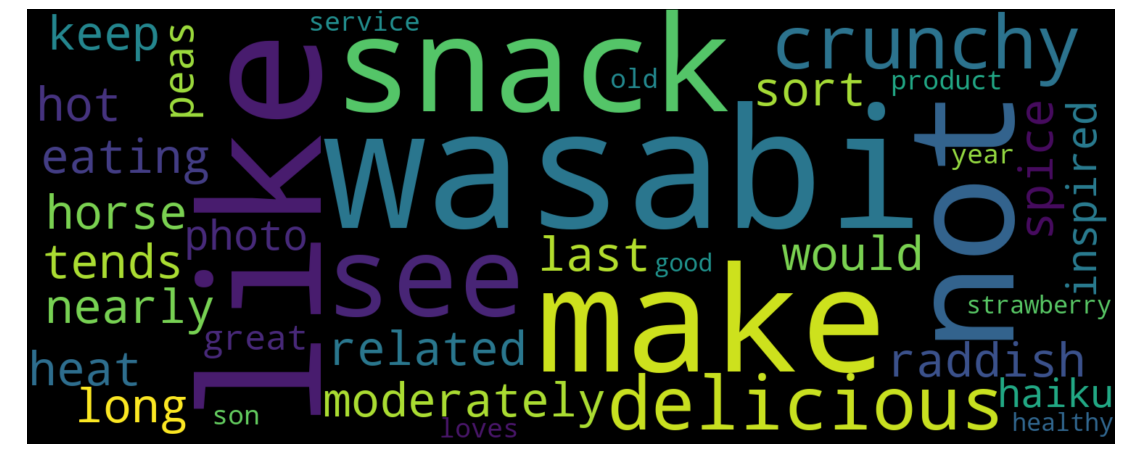

In [175]:
wordcloud(class_1)

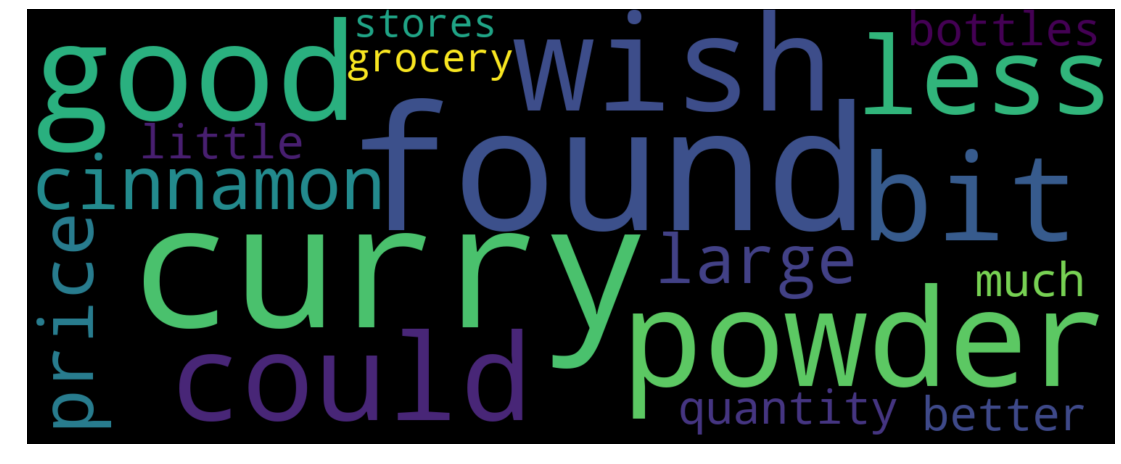

In [176]:
wordcloud(class_2)

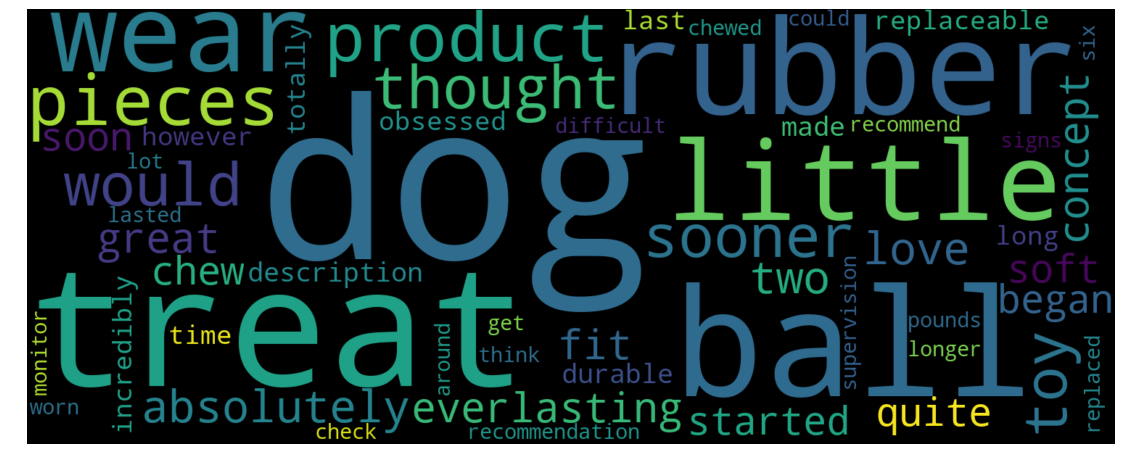

In [177]:
wordcloud(class_3)

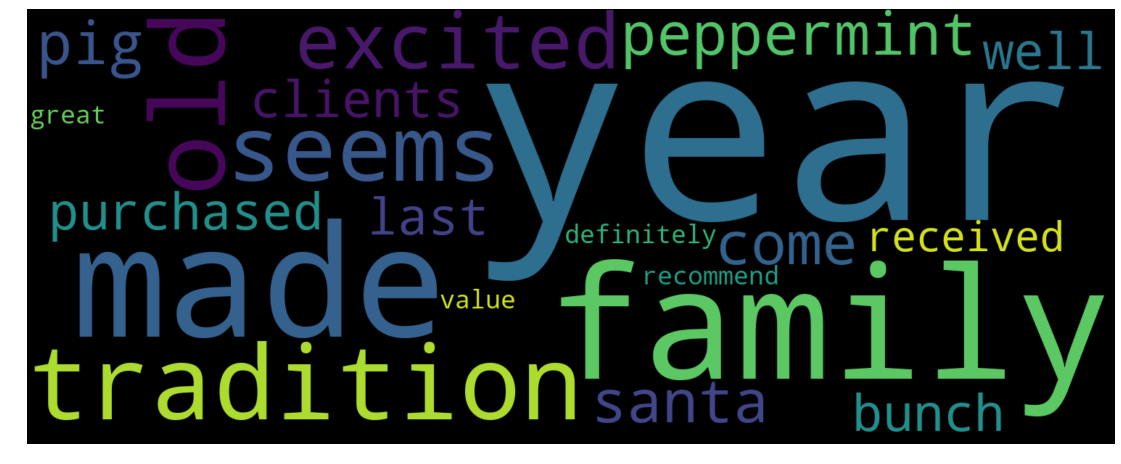

In [178]:
wordcloud(class_4)

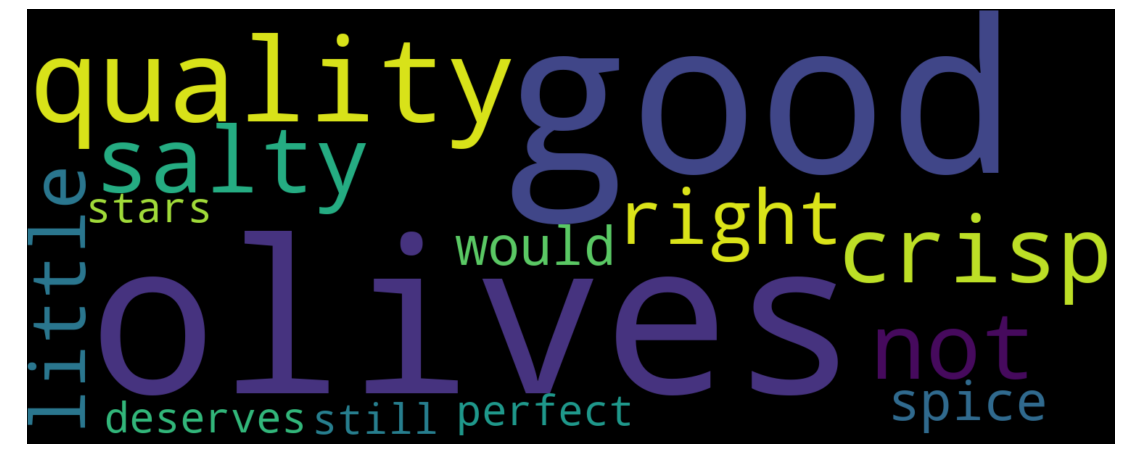

In [179]:
wordcloud(class_5)

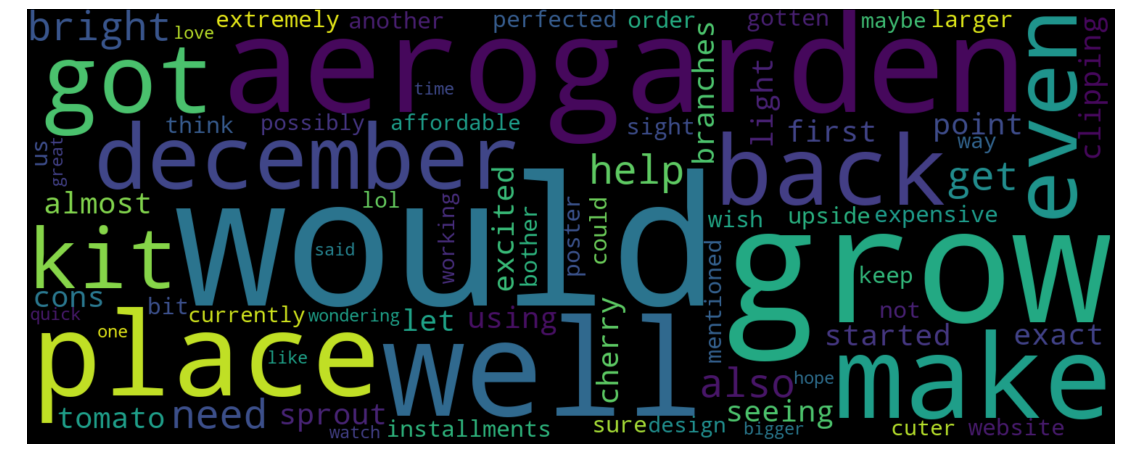

In [180]:
wordcloud(class_6)

### [5.6] Function that returns most similar words for a given word.

In [223]:
# Please write all the code with proper documentation
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim(word):
    similarity = []
    j = top_features.index(word)
    for i in  range(len(top_features)):
        similarity.append(cosine_similarity(U[j],U[i])[0][0])
        
    indices = np.argsort(similarity)[::-1]
    for j in indices[0:10]:
        print('most similar words to {} are {}'.format(word,top_features[j]))
    
    print("*************************************************************")
    
    
    

In [225]:
import warnings 
warnings.filterwarnings('ignore')
cos_sim(top_features[9])
cos_sim(top_features[111])

most similar words to howard are howard
most similar words to howard are eric
most similar words to howard are academy
most similar words to howard are limbs
most similar words to howard are camera
most similar words to howard are painfully
most similar words to howard are judged
most similar words to howard are orlando
most similar words to howard are companions
most similar words to howard are imbalance
*************************************************************
most similar words to snowed are snowed
most similar words to snowed are pittsburgh
most similar words to snowed are clark
most similar words to snowed are mulling
most similar words to snowed are kc
most similar words to snowed are kilo
most similar words to snowed are sacrificed
most similar words to snowed are mercola
most similar words to snowed are warehouses
most similar words to snowed are rectangles
*************************************************************


# [6] Conclusions and Procedure

__PROCEDURE__:

- Tfidf Vectorization was used to vectorize the data and top 2000 features i.e words according to the idf score were saved.

- Co - Occurence matrix was constructed on these top 2000 features using the whole review text corpus.

- Co-occurence matrix was used to construct the word vectors with lower dimensions.Thus this dimensionality reduction was done using the Truncated Singular Value Decomposition.And optimal Number of dimensions were found by how much they were able to explain the variance in data.

- After reducing the dimesnions ,K-means Clustering is performed to cluster the reviews and number of clusters were decided by plotting the elbow curve.

- Wordcloud is used to represent the words in each cluster to make some sense of the formation of clusters.

- Finally a similarity function is constructed which outputs the most similart words to an input word
 __CONCLUSIONS__: 

- coocurrence matrix was constructed using the window size=5 and it's interpretation was pretty similar to covriance matrix
- the optimal number of dimensions that we reduced the data to was around 280,and the optimal number of clusters were around 7.
- We also observed that 'flavour' and 'taste' themes dominated the contextual formation of clusters.
- Similarity function yielded the top similar features for an incoming word

__CONCLUSIONS__: 

- coocurrence matrix was constructed using the window size=5 and it's interpretation was pretty similar to covriance matrix
- the optimal number of dimensions that we reduced the data to was around 280,and the optimal number of clusters were around 7.
- We also observed that 'flavour' and 'taste' themes dominated the contextual formation of clusters.
- Similarity function yielded the top similar features for an incoming word